In [2]:
import os
import wandb
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import pandas as pd
import transformers
from datasets import load_dataset
import torch 
from tqdm import tqdm

from custom_datasets import PromptDataset
from finetuners import FinetunerConfig, GPTJ4bitFineTuner, GPTJ8bitFineTuner, LLaMA4bitFineTuner, LLaMA8bitFineTuner


LLAMA_7B_MODEL_PATH = 'decapoda-research/llama-7b-hf'
# !wget https://huggingface.co/decapoda-research/llama-7b-hf-int4/resolve/main/llama-7b-4bit.pt
LLAMA_7B_4BIT_CHECKPOINT_PATH = './llama-7b-4bit.pt'

LLAMA_13B_MODEL_PATH = 'decapoda-research/llama-13b-hf'
# !wget https://huggingface.co/decapoda-research/llama-13b-hf-int4/resolve/main/llama-13b-4bit.pt
LLAMA_13B_4BIT_CHECKPOINT_PATH = './llama-13b-4bit.pt'

GPTJ_6B_MODEL_PATH = 'EleutherAI/gpt-j-6B'


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 6.1
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/vetka/miniconda3/envs/transformers/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117_nocublaslt.so...


/home/vetka/miniconda3/envs/transformers/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /home/vetka/miniconda3/envs/transformers did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/home/vetka/miniconda3/envs/transformers/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('unix')}
  warn(msg)
/home/vetka/miniconda3/envs/transformers/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('VSCODE_WSL_EXT_LOCATION/up')}
  warn(msg)
/home/vetka/miniconda3/envs/transformers/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('vs/workbench/api/node/extensionHostProcess

The article on [Medium](https://medium.com/@vitaley.grechachin/how-to-train-a-capable-gpt-3-model-at-home-9c5b400ca7f), [Habr]()

# Prepare Data
## Required Data:
 * train and/or validation pandas DataFrame with two columns: prompt, completion
 * prompt + completion length must be less than 2048 tokens
 * For classification metrics completion must be 1 token


In [3]:
# example data

train_df = pd.read_csv('./data/train.csv')
val_df = pd.read_csv('./data/val.csv')

train_df.head()

label                                               text
0  offensive  RT @RAYCHIELOVESU: No &#8220;@3rdeyechillin: T...
1    neutral  &#8220;@__Black_Jesus: &#8220;@lil_aerii: Happ...
2       hate  &#8220;@iamkrause: No need to thank me, killin...
3  offensive  RT @tr4pb0y: when the pussy so good &amp; u fo...
4  offensive     I talk to these bitches like I really do care.

In [4]:
val_df.head()

label                                               text
0  neutral  RT @Black__Elvis: My favorite episode of Frien...
1     hate  RT @TankTopshotta: A real nigga gone teach his...
2     hate             Shoot that nigga an his shorty bitch .
3     hate  @_XoXoKelsey_ hell naw fuck them bitches serve...
4  neutral  @syd_renae okay cool then I'm not the only one...

<AxesSubplot: >

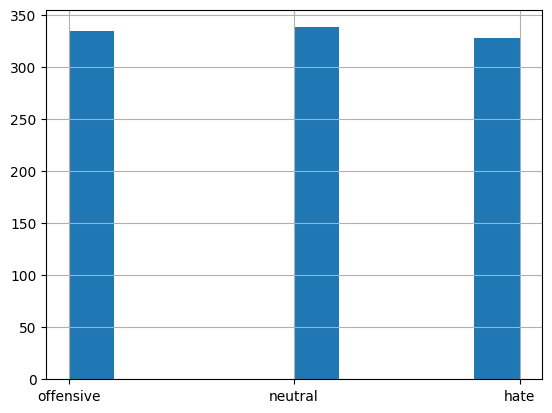

In [5]:
train_df['label'].hist()

In [24]:
# We can create prompt in 2 ways: instruction or raw text
# For instruction propmpt we will use a human understandable textual instruction.
# For raw prompt we will use raw text with special separator between propmpt and completion

def create_instruction_prompt(text, all_labels):
    prompt =  f'''Classify the following messages into one of the following categories: {', '.join(all_labels)}

Message: {text}

Category:'''
    return prompt

def create_raw_prompt(text):
    prompt =  f'''{text} /n/n###/n/n'''
    return prompt

# For classification task we need 1 token completion. The completion token must be in model vocabulary. 

# GPTJ
# GPTJ tokenization required completion tokens started with whitespace.

# train_df['completion'] = train_df['label'].apply(lambda x: ' '+ x)
# val_df['completion'] = val_df['label'].apply(lambda x: ' ' + x)

#LLaMA
to_replace = {'offensive': 'off'}
train_df['completion'] = train_df['label'].replace(to_replace)
val_df['completion'] = val_df['label'].replace(to_replace)

# instruction based prompt
all_labels = set(train_df['completion'].apply(lambda x: x.strip()).unique())
train_df['prompt'] = train_df['text'].apply(lambda x: create_instruction_prompt(x, all_labels))
val_df['prompt'] = val_df['text'].apply(lambda x: create_instruction_prompt(x, all_labels))


train_df.head()

label                                               text completion  \
0  offensive  RT @RAYCHIELOVESU: No &#8220;@3rdeyechillin: T...        off   
1    neutral  &#8220;@__Black_Jesus: &#8220;@lil_aerii: Happ...    neutral   
2       hate  &#8220;@iamkrause: No need to thank me, killin...       hate   
3  offensive  RT @tr4pb0y: when the pussy so good &amp; u fo...        off   
4  offensive     I talk to these bitches like I really do care.        off   

                                              prompt  
0  Classify the following messages into one of th...  
1  Classify the following messages into one of th...  
2  Classify the following messages into one of th...  
3  Classify the following messages into one of th...  
4  Classify the following messages into one of th...

### Prepare training and validation samples

In [25]:
# Create torch Datasets with prepared finetuning samples

# Load tokenizer and add padding token

# GPTJ
# tokenizer = transformers.AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")
# tokenizer.pad_token = tokenizer.eos_token

# LLaMA
tokenizer = transformers.LlamaTokenizer.from_pretrained(
    "decapoda-research/llama-7b-hf", add_eos_token=False
)

# Define max_prompt_size. Used to pad short prompts and truncate large prompts. Need for batching or fitting VRAM.
# We will take 0.99 quantile tokenized prompt length plus 1 token for completion. 
# Notice that we truncate only propmpt not completion.

max_prompt_size = int(pd.Series(len(tokenizer.tokenize(e)) for e in (train_df['prompt'] + ' ' + train_df['completion'])).quantile(0.99)) + 1


train_dataset = PromptDataset(train_df, tokenizer, max_prompt_len=max_prompt_size)
val_dataset = PromptDataset(val_df, tokenizer, max_prompt_len=max_prompt_size)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


# Finetuning of the best model

In [31]:
pl.seed_everything(100)

# logging in wandb
WANDB_PROJECT = "LLM_finetuning_hatetweets"
RUN_NAME = 'LLaMA_7B_8BIT_attention_lora'
wandb.login()
wandb_logger = WandbLogger(project=WANDB_PROJECT, name=RUN_NAME)



# Configuration
config = FinetunerConfig(target_lora_modules=["q_proj", "v_proj", "o_proj", "k_proj"],
                        lr=1e-4, 
                        batch_size=2,
                        num_epochs=3, 
                        adapter_dim=4,
                        lora_dropout=0,
                        lora_alpha=16,
                        classification=True)


# finetuner = GPTJ8bitFineTuner(
#                                 model_name=GPTJ_6B_MODEL_PATH,
#                                 fine_tuning_config=config, 
#                                 train_dataset=train_dataset,
#                                 val_dataset=val_dataset)

# finetuner = LLaMA4bitFineTuner(
#                                 model_name=LLAMA_7B_MODEL_PATH,
#                                 checkpoint_path='./llama-7b-4bit.pt',
#                                 fine_tuning_config=config, 
#                                 train_dataset=train_dataset,
#                                 val_dataset=val_dataset)

finetuner = LLaMA8bitFineTuner(
                                model_name=LLAMA_7B_MODEL_PATH,
                                fine_tuning_config=config, 
                                train_dataset=train_dataset,
                                val_dataset=val_dataset)

finetuner.load()

trainer = pl.Trainer(   logger=wandb_logger,    
                        log_every_n_steps=1,  
                        accelerator="gpu",                
                        max_epochs=config.num_epochs,
                        enable_checkpointing=False,
                    )

trainer.fit(finetuner)
wandb.finish()

Global seed set to 100
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vetka925. Use `wandb login --relogin` to force relogin


Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/vetka/miniconda3/envs/transformers/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type                 | Params
-----------------------------------------------
0 | model | PeftModelForCausalLM | 6.7 B 
-----------------------------------------------
2.1 M     Trainable params
6.7 B     Non-trainable params
6.7 B     Total params
26,962.051Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/vetka/miniconda3/envs/transformers/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/vetka/miniconda3/envs/transformers/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/vetka/miniconda3/envs/transformers/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('val_total_epoch_samples', ...)` in your `on_validation_epoch_end` but the value needs to be f

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Save model

In [8]:
if not os.path.exists('./loras'):
    os.mkdir('loras')
    
finetuner.model.save_pretrained('./loras/llama_7B_8bit_hatespeech_classification')

# Fine-tune report

[WanDB Report](https://api.wandb.ai/links/vetka925/qaqx6fhy)